In [1]:
import re
import csv
import yake
import spacy
import pandas as pd
# import en_core_web_sm
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
from datetime import datetime as dt
from reduce_memory_df import optimize_mem_usage

# nlp = en_core_web_sm.load()
pd.options.display.max_columns = None

In [15]:
df = pd.read_csv('data/amazon_reviews_us_Automotive_v1_00.tsv', sep='\t', quoting=csv.QUOTE_NONE)

In [16]:
%time df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3514942 entries, 0 to 3514941
Data columns (total 15 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   marketplace        3514942 non-null  object
 1   customer_id        3514942 non-null  int64 
 2   review_id          3514942 non-null  object
 3   product_id         3514942 non-null  object
 4   product_parent     3514942 non-null  int64 
 5   product_title      3514893 non-null  object
 6   product_category   3514942 non-null  object
 7   star_rating        3514942 non-null  int64 
 8   helpful_votes      3514942 non-null  int64 
 9   total_votes        3514942 non-null  int64 
 10  vine               3514942 non-null  object
 11  verified_purchase  3514942 non-null  object
 12  review_headline    3514926 non-null  object
 13  review_body        3514426 non-null  object
 14  review_date        3514942 non-null  object
dtypes: int64(5), object(10)
memory usage: 402.3+ MB
C

In [17]:
%time df.nunique()

CPU times: total: 10.3 s
Wall time: 10.4 s


marketplace                1
customer_id          1907652
review_id            3514942
product_id            762982
product_parent        703067
product_title         693152
product_category           1
star_rating                5
helpful_votes            472
total_votes              491
vine                       2
verified_purchase          2
review_headline      1660815
review_body          3127265
review_date             4156
dtype: int64

In [18]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,36075342,RAB23OVFNCXZQ,B00LPRXQ4Y,339193102,"17"" 2003-2006 Ford EXPEDITION Ford F150 2004-2...",Automotive,1,0,0,N,Y,"As it was used,","As it was used, the method that Ford used to a...",2015-08-31
1,US,42462164,R3NORADVJO6IE6,B000C7S0TO,907684644,Spectra Premium CU1909 Complete Radiator for T...,Automotive,5,0,0,N,Y,Five Stars,"Put it in fine, no problems. Shipping was dece...",2015-08-31
2,US,21241933,R299F4SO98S5OO,B000CO9WE4,752246352,K&N E-4665 High Performance Replacement Indust...,Automotive,5,1,1,N,Y,Great fit and performance on the surface drive...,Fit wonderfully on my 36HP Pro-Drive motor.,2015-08-31
3,US,52570308,R2DA9DOT03UW6I,B000GKD5NI,105401756,Suncutters Rear Window Shade,Automotive,5,2,3,N,Y,Good for the price. Fits fairly good on 2010 T...,Good for the price! So far I have put it up i...,2015-08-31
4,US,38200102,R2OGCH681EQHU6,B009SDA7TE,728471129,Lug Nuts Landcruiser Tundra OEM Mag 14x1.5 Thr...,Automotive,5,0,0,N,Y,Five Stars,Fit perfectly on my 2012 Tundra with stock alu...,2015-08-31


### Inspect the "not a number" or NaN values (aka null values)

In [19]:
print(df[df.review_body.isna()].shape)
df[df.review_body.isna()].head()

(516, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
8383,US,10433207,R1Z9FLI4EWEZ76,B00S1VMPDK,74224306,Dog Mom Hearts Black Plastic License Plate Fra...,Automotive,5,0,0,N,Y,Five Stars,NaN,2015-08-30
8433,US,106658,R2YRPPVXX4FKDA,B00IZNZOYQ,912240060,ABN 4 Cylinder Toyota/Lexus Oil Filter Wrench ...,Automotive,1,2,3,N,Y,Useless tool,NaN,2015-08-30
9244,US,9070651,R1QEOB3F7KK3YC,B00JVUFDOS,202897838,Rough Country Suspension 70507 Curved LED Ligh...,Automotive,5,0,0,N,Y,Five Stars,NaN,2015-08-30
10813,US,9070651,R23ZU63075A50B,B00SIIWO7I,976204821,"Penton 300w 52"" Inch LED Driving Work Light Ba...",Automotive,5,0,0,N,Y,Five Stars,NaN,2015-08-30
11955,US,3101982,R3LSPIC5GOS1VY,B000SOM9GQ,681787945,Bell 22-1-45915-8 Anti-Theft License Plate Fas...,Automotive,1,11,12,N,Y,One Star,NaN,2015-08-29


In [20]:
print(df[df.review_headline.isna()].shape)
df[df.review_headline.isna()].head()

(16, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
180394,US,600358,R15KN4Y5UTB6G8,B004F63XWW,904090647,CIPA 93186 Ultra White 1 Watt Powerful Bullet ...,Automotive,5,0,0,N,Y,NaN,its great for reverse lights<br /><br />2/13/1...,2015-08-01
384012,US,25704169,R11A931Q2ANSDM,B00LU44C72,698417339,"Victory Vegas Kingpin Hammer 1.5"" Lowering Lin...",Automotive,1,2,2,N,Y,NaN,If you install these you will need a fender li...,2015-06-26
1016860,US,42733858,R2JSDGVIQV1TU8,B000HPWIYY,802110114,Moog SSD11 Steering Damper Kit,Automotive,5,0,0,N,Y,NaN,Good product.,2015-02-28
1026564,US,41148150,R37H42LEY2SYX5,B00MWNZ1JI,401628912,Bosch Insight Wiper Blade,Automotive,1,0,0,N,N,NaN,These didn't fit my vehicle as advertised.,2015-02-26
1229867,US,35672222,R28GWZFP9ZRNNA,B000CJ2URA,537735876,Motorad 439-180 Thermostat,Automotive,1,0,1,N,Y,NaN,Returned,2015-01-14


### Combine review headline and body into a single review column

In [21]:
%%time
df.fillna('', inplace=True)
df['review'] = (df.review_headline + ' ' + df.review_body).str.strip()

CPU times: total: 7.84 s
Wall time: 7.96 s


#### Drop uneeded columns

In [22]:
df.drop(['marketplace','product_category','review_headline','review_body'], axis=1, inplace=True)

#### Reduce memory profile

In [23]:
optimize_mem_usage(df)

Memory usage of dataframe is 2,744,352,108 bytes
Memory usage after optimization is: 1,766,607,767 bytes
Decreased by -35.63%


In [24]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3514942 entries, 0 to 3514941
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   customer_id        3514942 non-null  int32   
 1   review_id          3514942 non-null  category
 2   product_id         3514942 non-null  category
 3   product_parent     3514942 non-null  int32   
 4   product_title      3514942 non-null  category
 5   star_rating        3514942 non-null  int8    
 6   helpful_votes      3514942 non-null  int16   
 7   total_votes        3514942 non-null  int16   
 8   vine               3514942 non-null  category
 9   verified_purchase  3514942 non-null  category
 10  review_date        3514942 non-null  category
 11  review             3514942 non-null  category
dtypes: category(7), int16(2), int32(2), int8(1)
memory usage: 398.7 MB


In [25]:
df.duplicated().sum()

0

In [26]:
%time df.to_parquet('data/amazon_reviews_automotive.parquet')

CPU times: total: 13.1 s
Wall time: 13.8 s


In [14]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review
0,32158956,R1KKOXHNI8MSXU,B01KL6O72Y,24485154,Easy Tool Stainless Steel Fruit Pineapple Core...,4,0,0,N,Y,2013-01-14,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKIN...
1,2714559,R26SP2OPDK4HT7,B01ID3ZS5W,363128556,V28 Women Cowl Neck Knit Stretchable Elasticit...,5,1,2,N,Y,2014-03-04,Favorite for winter. Very warm! I love this dr...
2,12608825,RWQEDYAX373I1,B01I497BGY,811958549,James Fiallo Men's 12-Pairs Low Cut Athletic S...,5,0,0,N,Y,2015-07-12,"Great Socks for the money. Nice socks, great c..."
3,25482800,R231YI7R4GPF6J,B01HDXFZK6,692205728,Belfry Gangster 100% Wool Stain-Resistant Crus...,5,0,0,N,Y,2015-06-03,Slick hat! I bought this for my husband and WO...
4,9310286,R3KO3W45DD0L1K,B01G6MBEBY,431150422,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,5,0,0,N,Y,2015-06-12,I would do it again! Perfect dress and the cus...


In [80]:
df.product_title.value_counts()

San Francisco Bay One Cup                                              17032
Viva Naturals Organic Extra Virgin Coconut Oil, 16 Ounce               10068
Nutiva Organic Virgin Coconut Oil, 15 Ounce                             5798
Davidson's Tea Bulk                                                     5716
Grove Square Cappuccino, Single Serve Cup for Keurig K-Cup Brewers      5146
                                                                       ...  
Julia's Southern Magnolia Buttered Yellow Grits                            1
Julia's Wild Boar Sassy Sauce and Marinade Mix - Makes 1qt.                1
Julian Bakery Carb Zero Bread Cinnamon                                     1
Julian Bakery Smart Carb #2 Cinnamon Raisin Low Carb Bread Original        1
요뽀끼 Yopokki                                                                1
Name: product_title, Length: 273649, dtype: int64

In [84]:
products = df.product_title.value_counts()[df.product_title.value_counts()>50].index.tolist()

In [100]:
result = df[df.product_title.apply(lambda x: x in products)].copy()

In [87]:
df.shape, result.shape

((2402458, 12), (1185229, 12))

In [89]:
f'{df.shape[0] - result.shape[0]:,.0f}'

'1,217,229'

In [90]:
f'{(result.shape[0]-df.shape[0])/df.shape[0]:,.2%} reduction'

'-50.67% reduction'

In [107]:
result.reset_index(drop=True, inplace=True)

In [91]:
df.groupby('product_title').star_rating.value_counts().to_frame().iloc[:10]

star_rating
product_title                                      star_rating             
" Cuca" Cockles (Berberechos) in Brine 4 Oz (Ca... 2                      1
                                                   4                      1
                                                   5                      1
" Cuca" Mussels ( Mejillones) in Pickle Sauce 4... 5                      4
" Cuca" Stuffed Whole Squid (Calamares) in Ink ... 3                      1
" Cuca" Ventresca White Tuna in Olive Oil 4 Oz ... 5                      4
                                                   3                      2
" Cuca" White Tuna (Bonito Del Norte) Fillets i... 5                      1
" NEW " Powdered Coca Tea Matcha Style Yungas G... 5                      2
"1-light" Fluorescent Strip Light 18" - White.     5                      1

In [52]:
summary = df.groupby('product_title').star_rating.value_counts().to_frame()

In [54]:
summary.columns = ['counts']

In [64]:
summary.sort_values(by=['counts','product_title'],ascending=[False, False])

,,counts
product_title,star_rating,
San Francisco Bay One Cup,5,12397
"Viva Naturals Organic Extra Virgin Coconut Oil, 16 Ounce",5,8481
"Nutiva Organic Virgin Coconut Oil, 15 Ounce",5,4909
Davidson's Tea Bulk,5,3788
Keurig Green Mountain Coffee K-Cup Packs,5,3723
...,...,...
""" Cuca"" White Tuna (Bonito Del Norte) Fillets in Olive Oil 8 Oz (Glass)",5,1
""" Cuca"" Stuffed Whole Squid (Calamares) in Ink Sauce 4 Oz (Canned)",3,1
""" Cuca"" Cockles (Berberechos) in Brine 4 Oz (Canned)",2,1


In [76]:
df[df.star_rating==1].sort_values(by='product_parent')

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review
646028,10063994,RKZR40M3LD6CI,B00JAND6Z4,6450,Nature's Mojo Cranberry Fruit Fiber Powder 1lb,1,0,0,N,Y,2015-01-29,No Taste Tastes just like sawdust!!!
1867922,18486414,R1TI3LISM2OM71,B004BJYQ4C,10982,Myojo Chukazanmai Hiyashi Chuka Instant Cold N...,1,1,11,N,Y,2013-02-07,This Hiyashi Chuka disappointed me I saw the 5...
654262,10614819,R299DIN9G2MOKM,B00BINQQSS,20797,"Olive Garden Signature Italian Salad Dressing,...",1,0,0,N,Y,2015-01-26,Instead of the Olive Garden signature dressing...
730710,21980412,R3HSHBHDU3WMLM,B004H4P6VI,82758,"Bisto Gravy Granules Red, 6-Ounce (Pack of 6)",1,0,3,N,Y,2015-01-03,"Not the same Not like I expected, poor qualit..."
654673,14367240,RSYP4S8530APC,B000YHLS8W,134830,"Kashi TLC Cookies, 8.5-Ounce Boxes",1,1,1,N,N,2015-01-26,Dry and flavorless These cookies were so dry a...
...,...,...,...,...,...,...,...,...,...,...,...,...
203218,10994563,R3MQ1IZCVA0T4F,B00QUAR66A,999962201,Frozen Ice Blue Snowflakes,1,1,1,N,Y,2015-06-22,One Star Poor quality would not purchase again.
132702,47479761,R13V5H23657MHY,B00QUAR66A,999962201,Frozen Ice Blue Snowflakes,1,1,1,N,Y,2015-07-17,Would have like them alittle bigger and thicke...
1398340,30408035,R2L9O44LU30E9H,B00GR6HPHM,999998597,Starbucks French Roast Coffee 1 Lb (16 Oz) - W...,1,1,1,N,Y,2014-02-08,Throwing it out. This coffee is old. Typically...
1469974,16361236,R3C4YOF03L1NDO,B00GR6HPHM,999998597,Starbucks French Roast Coffee 1 Lb (16 Oz) - W...,1,1,1,N,Y,2013-12-30,Tastes Like Chemicals! DO NOT BUY When I first...


In [24]:
fig = px.bar(df.star_rating.value_counts().to_frame(), 
title='Star Ratings Distribution')

fig.update_traces(
    marker_line_width=1, 
    marker_line_color='black',
    marker=dict(color='#3f9c35'),
)

fig.update_xaxes(title='Star Rating (1 to 5)',
                 gridcolor='lightgray',
                 showgrid=True, 
                 gridwidth=1)

fig.update_yaxes(title='Number of Ratings',
                 gridcolor='lightgray',
                 showgrid=True, 
                 gridwidth=1)

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  hoverlabel=dict(
                      bgcolor='ivory',
                      font_size=16,
                      font_family='Rockwell'),
                  font=dict(family='Rockwell', 
                            color='navy',
                            size=16), 
                  title_x=0.5)
fig.show()

In [66]:
_df = df.star_rating.value_counts().to_frame().reset_index().rename(
    columns={'index':'star_rating','star_rating':'count'})

_df['count'] = _df['count']/_df['count'].sum()

fig = px.pie(_df,
             values='count',
             names='star_rating',
             labels='star_rating', 
             title='Star Ratings Distribution'+\
             '<br><sup>hover over to see labels</sup>',
             hole=0.5, color_discrete_sequence=px.colors.qualitative.Dark24_r, 
             width=500, height=500).update_traces(marker_line_color='rgb(0,0,0)',
                                                  textinfo='label+percent',
                                                  hovertemplate='<br>'.join([
                                                      'Star Rating:  %{label}',
                                                      'Count:  %{value:,.2%}'
                                                      ]),
                                                  textfont_size=16,
                                                  marker_line_width=2)
fig.update_layout(title_font_size=20,
                  showlegend=False,
                  hoverlabel=dict(
                      font_size=16,
                      font_family='Rockwell'),
                  font=dict(family='Rockwell', 
                            color='navy',
                            size=12), 
                  title_x=0.5)
fig.show()

In [16]:
amazon = df[df.product_title.apply(lambda x: '[Amazon.com Exclusive]' in x)]

In [17]:
for title in amazon.product_title:
    print(title)

LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]
LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]
LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]
LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]
LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]
LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]
LU Erin Fetherston Designed, Creme Roulee Dark Chocolate European Style Rolled Wafers, 14.1-Ounce Canisters (Pack of 3) [Amazon.com Exclusive]

In [6]:
df.review_date = df.review_date.astype('O').apply(dt.fromisoformat)
df['review_month'] = df.review_date.apply(lambda x: x.month)
df['review_day'] = df.review_date.apply(lambda x: x.day)
df['review_year'] = df.review_date.apply(lambda x: x.year)

In [8]:
f'{df.memory_usage(deep=True).sum():,.0f}'

'1,399,630,128'

In [111]:
_df = df.review_month.value_counts().reset_index().rename(
    columns={'index':'review_month', 'review_month':'count'})

fig = px.bar(
    _df, 
    x='review_month', 
    y='count', 
    title='Quantity of Reviews By Month')

fig.update_xaxes(
    title='Review Month',
    gridcolor='lightgray',
    showgrid=True, 
    gridwidth=1)

fig.update_yaxes(
    title='Number of Reviews',
    gridcolor='lightgray',
    showgrid=True, 
    gridwidth=1)

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=20,
    showlegend=False,
    hoverlabel=dict(
        bgcolor='ivory',
        font_size=16,
        font_family='Rockwell'),
    font=dict(family='Rockwell', 
            color='navy',
            size=14), 
    title_x=0.5)

fig.show()

In [112]:
_df = df.review_day.value_counts().reset_index().rename(
    columns={'index':'review_day', 'review_day':'count'})

fig = px.bar(
    _df, 
    x='review_day', 
    y='count', 
    title='Quantity of Reviews By Day')

fig.update_xaxes(
    title='Review Day',
    gridcolor='lightgray',
    showgrid=True, 
    gridwidth=1)

fig.update_yaxes(
    title='Number of Reviews',
    gridcolor='lightgray',
    showgrid=True, 
    gridwidth=1)

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title_font_size=20,
    showlegend=False,
    hoverlabel=dict(
        bgcolor='ivory',
        font_size=16,
        font_family='Rockwell'),
    font=dict(family='Rockwell', 
            color='navy',
            size=14), 
    title_x=0.5)

fig.show()

In [129]:
df.review_date.apply(lambda x: x.year).value_counts()

fig = px.line(
    df.review_date.apply(lambda x: x.year).value_counts(), 
    title='Number of Reviews Over Time')

fig.update_traces(mode='markers+lines')

fig.update_xaxes(title='Year',
    gridcolor='lightgray',
                 showgrid=True, 
                 gridwidth=1)

fig.update_yaxes(title='Number of Reviews',
    gridcolor='lightgray',
                 showgrid=True, 
                 gridwidth=1)

fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  title_font_size=20,
                  showlegend=False,
                  hoverlabel=dict(
                      bgcolor='ivory',
                      font_size=16,
                      font_family='Rockwell'),
                  font=dict(family='Rockwell', 
                            color='navy',
                            size=14), 
                  title_x=0.5)

fig.show()

In [26]:
df.sort_values(by='total_votes', ascending=False)

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2344167,47364506,RXXPVOUH9NLL3,B00032G1S0,753469671,"Tuscan Dairy Whole Vitamin D Milk, Gallon, 128 oz",5,23755,24170,N,N,Make this your only stock and store,"Once upon a mid-day sunny, while I savored Nut...",2008-07-08
923600,29857793,R2DQNJRV27D3P0,B000EVOSE4,990977895,"Haribo Gummi Candy Gold-Bears,",5,11045,11901,N,N,I have seen the face of God.,I didn't feel the need to plan my weekend arou...,2014-10-22
2393030,49234072,RKT07YYORZMZE,B00032G1S0,753469671,"Tuscan Dairy Whole Vitamin D Milk, Gallon, 128 oz",3,9986,10304,N,N,"One Friday, Without the Milk",He always brought home milk on Friday. <br /> ...,2006-10-30
1756395,9286343,R3SC3RFGX29KPJ,B00012182G,554396858,Fresh Whole Rabbit,1,7886,8076,N,N,Not like Game of Thrones,Brad and I were very excited to order a few of...,2013-05-10
249057,809523,R2JGNJ5ZPJT4YC,B000EVOSE4,990977895,"Haribo Gummi Candy Gold-Bears,",1,6201,6900,N,N,"See you in hell, Haribo Sugar-Free Gummi Bears","It was my last class of the semester, and the ...",2015-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
920063,41928415,R48P5I6RBY7RK,B007Y59HVM,267956568,San Francisco Bay One Cup,5,0,0,N,Y,hal-price per k-cup!!!,"great product, great price, but use your own c...",2014-10-24
920062,10993703,R1JJ3QLVVHML01,B000FFLTD2,893081147,Dr. McDougall's Right Foods Vegan Pad Thai Noo...,5,0,0,N,N,Five Stars,The Pad Thai soup is delicious and so quick to...,2014-10-24
920059,17522687,R3Q6NR2WWXPKLZ,B00M2OGS08,715217277,Surge Citrus Flavored Soda 16fl oz. 12 cans,5,0,0,N,Y,Five Stars,It was excellent just like I remembered,2014-10-24
920057,43724923,RJFN6IAQ1MNEF,B008MIGHFE,854138558,Health Warrior Chia Bars,4,0,0,N,Y,Good,Tasty bars. Good price,2014-10-24


In [24]:
df.sort_values(by='helpful_votes', ascending=False).review_body.iloc[4]

"It was my last class of the semester, and the final exam was worth 30% of our grade.<br />After a late night study session I felt confident, but I had to decide between sleeping in or cooking breakfast. My eyelids chose sleep.<br />My stomach later regretted this decision, and after several uncomfortable stomach growls, I finally decided to make a quick stop by the campus bookstore and grab a snack before my test. Since the semester was ending and everyone was going home for the summer, a lot of items were on sale, including the snacks and candy that they kept up front. Being in the hungry state that I was in, it felt only logical to pick the largest, yet least expensive candy in order to get more bang for my buck.<br />And there they sat: two bags of Haribo Sugar-Free Gummi Bears, buy one get one free.<br />&#34;What a deal!&#34; I thought naïvely. I would eat one bag before my test, and one bag afterwards.<br />As I walked to class, I gleefully chewed on those abominable little bast

In [127]:
df.sort_values(by='helpful_votes', ascending=False).helpful_votes.iloc[4]

6201

In [128]:
df.sort_values(by='helpful_votes', ascending=False).iloc[4]

customer_id                                                     809523
review_id                                               R2JGNJ5ZPJT4YC
product_id                                                  B000EVOSE4
product_parent                                               990977895
product_title                           Haribo Gummi Candy Gold-Bears,
star_rating                                                          1
helpful_votes                                                     6201
total_votes                                                       6900
vine                                                                 N
verified_purchase                                                    N
review_headline         See you in hell, Haribo Sugar-Free Gummi Bears
review_body          It was my last class of the semester, and the ...
review_date                                        2015-06-05 00:00:00
review_month                                                         6
review

In [155]:
groups = df.groupby('review_year')

fig = px.scatter()

for group in groups:
    fig.add_trace(
        go.Scatter(
            y=group[1]['review_day'].value_counts(),
            name=str(group[1]['review_year'].iloc[0]),
            showlegend=True,
        )
    )

fig.update_traces(
    mode='markers+lines',
    hovertemplate='Number of Reviews: %{y}')

fig.update_xaxes(title='Day',
    gridcolor='lightgray',
                 showgrid=True, 
                 gridwidth=1)

fig.update_yaxes(title='Number of Reviews',
    gridcolor='lightgray',
                 showgrid=True, 
                 gridwidth=1)

fig.update_layout(title='Reviews Over Time',
    paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  title_font_size=20,
                  showlegend=False,
                  hoverlabel=dict(
                      bgcolor='ivory',
                      font_size=16,
                      font_family='Rockwell'),
                  font=dict(family='Rockwell', 
                            color='navy',
                            size=14), 
                  title_x=0.5)

fig.show()

In [18]:
docs = df.review_headline.astype('O').copy() + ' ' + df.review_body.astype('O').copy()

In [19]:
docs

0          Using these for years - love them. As a family...
1          Wonderful My favorite nut.  Creamy, crunchy, s...
2          Five Stars This green tea tastes so good! My g...
3          Five Stars I love Melissa's brand but this is ...
4                                            Five Stars good
                                 ...                        
2402453    Different The Amor Belhom Duo are likely the o...
2402454    This  Horse  Is  Gorgourges! Being  a  Breyer ...
2402455    brilliant, realistic model! This model is beau...
2402456    don't have it yet..but  will soon As a person ...
2402457    Great This Breyer horse is wonderful. She is b...
Length: 2402458, dtype: object

In [38]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [39]:
def tokenize(doc):
    doc = re.sub('[^a-z]', ' ', doc.lower())
    doc = re.sub('<[^<]+?>', '', doc)
    tokens = word_tokenize(doc)
    lem = WordNetLemmatizer().lemmatize
    tokens = [lem(token,'a').strip() for token in tokens if token not in nlp.Defaults.stop_words]
    tokens = [lem(token,'v').strip() for token in tokens if token not in nlp.Defaults.stop_words]
    return tokens

In [24]:
def tokenize(doc):
    doc = re.sub('[^a-z]', ' ', doc.lower())
    doc = nlp(doc)
    tokens = [token.lemma_ for token in doc if token not in nlp.Defaults.stop_words]
    return tokens

In [52]:
tokenize('This is a, and !!! nothing is making me $))() smellier sentences about driving and drivers eating')

['make', 'smelly', 'sentence', 'drive', 'drivers', 'eat']

In [2]:
df = pd.read_parquet('data/amazon_reviews_grocery.parquet')

In [3]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review
0,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",5,0,0,N,Y,2015-08-31,Using these for years - love them. As a family...
1,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",5,0,0,N,Y,2015-08-31,"Wonderful My favorite nut. Creamy, crunchy, s..."
2,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,5,0,0,N,N,2015-08-31,Five Stars This green tea tastes so good! My g...
3,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,5,0,0,N,Y,2015-08-31,Five Stars I love Melissa's brand but this is ...
4,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",5,0,0,N,Y,2015-08-31,Five Stars good


In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2402458 entries, 0 to 2402457
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   customer_id        2402458 non-null  int32   
 1   review_id          2402458 non-null  category
 2   product_id         2402458 non-null  category
 3   product_parent     2402458 non-null  int32   
 4   product_title      2402458 non-null  category
 5   star_rating        2402458 non-null  int8    
 6   helpful_votes      2402458 non-null  int16   
 7   total_votes        2402458 non-null  int16   
 8   vine               2402458 non-null  category
 9   verified_purchase  2402458 non-null  category
 10  review_date        2402458 non-null  category
 11  review             2402458 non-null  category
dtypes: category(7), int16(2), int32(2), int8(1)
memory usage: 260.9 MB


In [14]:
kw_extractor = yake.KeywordExtractor(n=1, top=5)

In [17]:
keywords = [kw_extractor.extract_keywords(text) for text in df.product_title.cat.categories]

In [20]:
for i, w in enumerate(keywords):
    if i > 10:
        break
    print(w)

[('Cuca', 0.030396371632413578), ('Cockles', 0.030396371632413578), ('Berberechos', 0.030396371632413578), ('Canned', 0.030396371632413578), ('Brine', 0.08596317751626563)]
[('Pickle Sauce', 0.012602360123953448), ('Cuca', 0.030396371632413578), ('Mussels', 0.030396371632413578), ('Mejillones', 0.030396371632413578), ('Canned', 0.030396371632413578)]
[('Stuffed Whole Squid', 0.007444681613352736), ('Ink Sauce', 0.012602360123953448), ('Cuca', 0.030396371632413578), ('Calamares', 0.030396371632413578), ('Canned', 0.030396371632413578)]
[('Ventresca White Tuna', 0.001881309737406442), ('Ventresca White', 0.012602360123953448), ('Olive Oil', 0.012602360123953448), ('White Tuna', 0.02140921543860024), ('Tuna in Olive', 0.02140921543860024)]
[('Bonito Del Norte', 0.0011031048803583578), ('White Tuna', 0.007444681613352736), ('Bonito Del', 0.012602360123953448), ('Del Norte', 0.012602360123953448), ('Fillets in Olive', 0.012602360123953448)]
[('Powdered Coca Tea', 0.001881309737406442), ('St

In [32]:
keywords[-7]

'Official Herbal Tea'

In [34]:
import psutil
psutil.Process().memory_info().rss / (1024 * 1024)

2198.05859375

In [37]:
str(keywords[0])

"[('Cuca', 0.030396371632413578), ('Cockles', 0.030396371632413578), ('Berberechos', 0.030396371632413578), ('Canned', 0.030396371632413578), ('Brine', 0.08596317751626563)]"

In [41]:
with open('keywords.txt', 'w') as f:
    for k in keywords:
        try:
            f.write(str(k))
        except Exception as e:
            f.write(e.args[0])
    f.close()

In [4]:
good_reviews_df = df[df.star_rating >= 4]

In [5]:
bad_reviews_df = df[df.star_rating < 4]

In [6]:
bad_reviews_df.shape

(446808, 12)

In [38]:
text = ' '.join(bad_reviews_df.review.tolist())
text = re.sub('<[^<]+?>', '', text)

In [39]:
f'{len(text):,}'

'144,083,794'

CPU times: total: 57.5 s
Wall time: 58.5 s


(-0.5, 399.5, 199.5, -0.5)

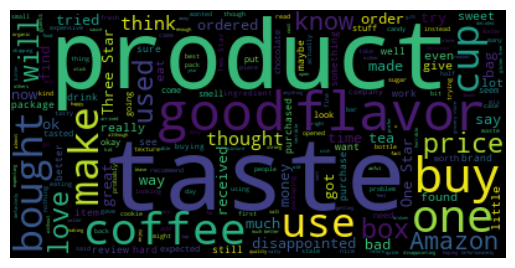

In [43]:
%%time
cloud = WordCloud().generate(text)
fig = plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')


In [44]:
text = ' '.join(good_reviews_df.review.tolist())
text = re.sub('<[^<]+?>', '', text)

In [45]:
f'{len(text):,}'

'487,973,857'

CPU times: total: 3min 56s
Wall time: 4min 6s


(-0.5, 399.5, 199.5, -0.5)

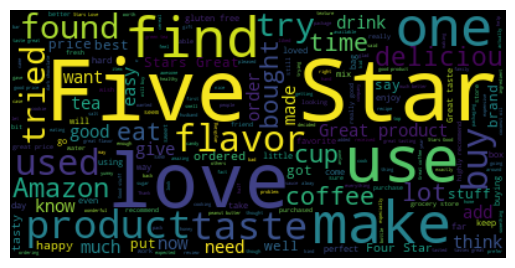

In [46]:
# %%time
cloud2 = WordCloud().generate(text)
fig2 = plt.imshow(cloud2, interpolation='bilinear')
plt.axis('off')

In [48]:
df.head()

,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_date,review
0,42521656,R26MV8D0KG6QI6,B000SAQCWC,159713740,"The Cravings Place Chocolate Chunk Cookie Mix,...",5,0,0,N,Y,2015-08-31,Using these for years - love them. As a family...
1,12049833,R1OF8GP57AQ1A0,B00509LVIQ,138680402,"Mauna Loa Macadamias, 11 Ounce Packages",5,0,0,N,Y,2015-08-31,"Wonderful My favorite nut. Creamy, crunchy, s..."
2,107642,R3VDC1QB6MC4ZZ,B00KHXESLC,252021703,Organic Matcha Green Tea Powder - 100% Pure Ma...,5,0,0,N,N,2015-08-31,Five Stars This green tea tastes so good! My g...
3,6042304,R12FA3DCF8F9ER,B000F8JIIC,752728342,15oz Raspberry Lyons Designer Dessert Syrup Sauce,5,0,0,N,Y,2015-08-31,Five Stars I love Melissa's brand but this is ...
4,18123821,RTWHVNV6X4CNJ,B004ZWR9RQ,552138758,"Stride Spark Kinetic Fruit Sugar Free Gum, 14-...",5,0,0,N,Y,2015-08-31,Five Stars good


In [10]:
bad_reviews_df.review

5                           Not Happy The popcorn was stale.
9          Disgusting now and difficult on digestion Used...
17         1 Out Of 5 Of My Co-Workers Thought It Was "Ok...
23         pita crackers not craze about these. nothing r...
26                                    Three Stars it's gum..
                                 ...                        
2402389    Good but linear The Economist is a good magazi...
2402392    This is NOT soy! Perhaps they've confused prod...
2402402    Stick with the Mint ... I am a HUGE lover of F...
2402408    Excellent writing from a corporate globalist p...
2402410    Cappuccino without flavor I am an experienced ...
Name: review, Length: 446808, dtype: category
Categories (2258673, object): ['..., '..., '..., '..., ..., '😎 They are delicious. Great for hangovers.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
# %%time
vectorizer = TfidfVectorizer(stop_words=nlp.Defaults.stop_words, tokenizer=tokenize)
tfidf = vectorizer.fit_transform(bad_reviews_df.review)

c:\Users\E079051\Desktop\Product_Reviews_Analysis\venv\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'll', 'm', 'n', 's', 't', 've'] not in stop_words.
  warnings.warn(


CPU times: total: 3min 42s
Wall time: 3min 44s


In [41]:
tfidf

<446808x91177 sparse matrix of type '<class 'numpy.float64'>'
	with 9324186 stored elements in Compressed Sparse Row format>

In [43]:
feature_names = vectorizer.get_feature_names_out()

In [48]:
doc = 5
feature_index = tfidf[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf[doc, x] for x in feature_index])


for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w,s)

great 0.1880500737732485
ok 0.2187069145838935
way 0.21173729856189388
good 0.12731249780117412
bulgogi 0.6915244515368749
korean 0.4784577876891703
remind 0.35504167667843384
flavor 0.15026904443691116


In [80]:
import numpy as np

In [110]:
scores = [np.array(x)[0][0] for x in list(tfidf.T.sum(axis=1))]

In [104]:
feature_names

array(['aa', 'aaa', 'aaaaa', ..., 'zzzzzzzzzzzz', 'zzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

In [112]:
scored = dict(zip(feature_names, scores))

CPU times: total: 391 ms
Wall time: 370 ms


(-0.5, 399.5, 199.5, -0.5)

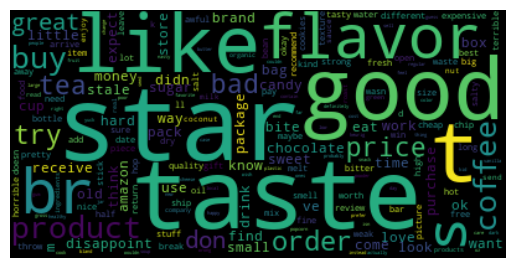

In [116]:
%%time
cloud = WordCloud().generate_from_frequencies(scored)
fig = plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')

In [120]:
good_sample = good_reviews_df.review.sample(bad_reviews_df.shape[0])

In [121]:
good_sample

1203733    Taste great. It tastes great and I would like ...
61689      Good candy It arrived in perfect condition & t...
763192     Five Stars Quality product exactly what I orde...
2192989    scottish haggis bought this as a joke for a pe...
701127                        Five Stars Very fresh and good
                                 ...                        
511136                       Five Stars Nice taste very good
1738016    Tasty and healthy tea My husband loves this ch...
1342873    amazing coffee! Thank you very much, the selec...
1906513    I've used it 2 years. This product can be subs...
461034                               Five Stars Perfect size
Name: review, Length: 446808, dtype: category
Categories (2258673, object): ['..., '..., '..., '..., ..., '😎 They are delicious. Great for hangovers.

In [122]:
%%time
vectorizer2 = TfidfVectorizer(stop_words=nlp.Defaults.stop_words, tokenizer=tokenize)
tfidf2 = vectorizer2.fit_transform(good_sample)

c:\Users\E079051\Desktop\Product_Reviews_Analysis\venv\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['d', 'll', 'm', 'n', 's', 't', 've'] not in stop_words.
  warnings.warn(


CPU times: total: 3min 20s
Wall time: 3min 25s


In [123]:
tfidf2

<446808x79569 sparse matrix of type '<class 'numpy.float64'>'
	with 7788567 stored elements in Compressed Sparse Row format>

In [125]:
feature_names2 = vectorizer2.get_feature_names_out()

In [ ]:
doc = 5
feature_index = tfidf[doc,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidf[doc, x] for x in feature_index])


for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print(w,s)

great 0.1880500737732485
ok 0.2187069145838935
way 0.21173729856189388
good 0.12731249780117412
bulgogi 0.6915244515368749
korean 0.4784577876891703
remind 0.35504167667843384
flavor 0.15026904443691116


In [126]:
scores2 = [np.array(x)[0][0] for x in list(tfidf2.T.sum(axis=1))]

In [127]:
feature_names2

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzzzzzzzz', 'zzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype=object)

In [128]:
scored2 = dict(zip(feature_names2, scores2))

CPU times: total: 391 ms
Wall time: 427 ms


(-0.5, 399.5, 199.5, -0.5)

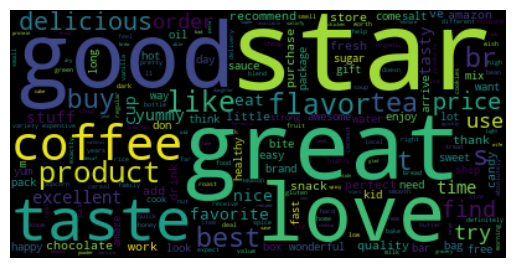

In [129]:
%%time
cloud2 = WordCloud().generate_from_frequencies(scored2)
fig2 = plt.imshow(cloud2, interpolation='bilinear')
plt.axis('off')

In [133]:
test = df.product_id.value_counts()

In [168]:
x = test[test>50].index.tolist()

In [142]:
groups = df.groupby('product_id')

In [143]:
x = []
for group in groups:
    x.append(group)

In [150]:
idx = [x[i][1].index[0] for i in range(len(x))]

In [171]:
more_then_50_reviews = df[df.product_id.apply(lambda y: y in x)]

In [174]:
(more_then_50_reviews.shape[0] - df.shape[0])/df.shape[0], more_then_50_reviews.shape, df.shape

(-0.5850953481809047, (996791, 12), (2402458, 12))

In [175]:
x = test[test>25].index.tolist()

In [176]:
more_then_25_reviews = df[df.product_id.apply(lambda y: y in x)]

In [177]:
(more_then_25_reviews.shape[0] - df.shape[0])/df.shape[0], more_then_25_reviews.shape[0], df.shape[0]

(-0.4354577686685886, 1356289, 2402458)

In [180]:
df.iloc[:100,:].to_csv('data/test.csv', index=False)

In [49]:
# %time 
df2 = pd.read_csv('data/amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', quoting=csv.QUOTE_NONE)

CPU times: total: 58.8 s
Wall time: 1min 1s


In [52]:
df2.product_category.unique()

array(['Books', 'Music', 'Video', 'Video DVD', 'Toys', 'Tools',
       'Office Products', 'Video Games', 'Software',
       'Digital_Music_Purchase', 'Home Entertainment', 'Electronics',
       'Digital_Ebook_Purchase', 'Digital_Video_Download', 'Kitchen',
       'Camera', 'Outdoors', 'Musical Instruments', 'Sports', 'Watches',
       'PC', 'Home', 'Wireless', 'Beauty', 'Baby', 'Home Improvement',
       'Apparel', 'Shoes', 'Lawn and Garden', 'Mobile_Electronics',
       'Health & Personal Care', 'Grocery', 'Luggage',
       'Personal_Care_Appliances', 'Automotive', 'Mobile_Apps',
       'Furniture', 'Pet Products'], dtype=object)

In [53]:
df2.shape

(6931166, 15)

In [60]:
df2.fillna('', inplace=True)
df2['review'] = (df2.review_headline + ' ' + df2.review_body).str.strip()

In [61]:
print(df2[df2.review_body.isna()].shape)
df2[df2.review_body.isna()].head()

(0, 16)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review


In [59]:
print(df2[df2.review_headline.isna()].shape)
df2[df2.review_headline.isna()].head()

(74, 16)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review
144995,US,51263804,RRR6EK045G5YL,630438551X,212477251,Romeo & Juliet [VHS],Video,5,4,8,N,N,NaN,I consider myself to be a pretty much diehard ...,2001-03-21,NaN
274671,US,34490235,R25MC0QXPV5CRZ,6305949980,664817538,The Nightmare Before Christmas (Special Edition),Video DVD,4,1,6,N,N,NaN,"Three words, \\""BEST MOVIE EVER.\\"" If you hav...",2002-12-11,NaN
373462,US,23532323,R1MNPI81JJ62NI,B0000DD7NL,868764779,The Diary of Alicia Keys,Music,5,0,2,N,N,NaN,I love this cd! My favorite two songs are:<br...,2004-01-12,NaN
450504,US,43058957,RIHK7J9KBB62V,B00005V3Z4,681790048,Donnie Darko (Widescreen Edition),Video DVD,4,3,8,N,N,NaN,It actually is pretty hard to classify this mo...,2004-11-18,NaN
515665,US,34215909,R1HAKDWL5X86B9,B00014NE62,59241661,Maurice - The Merchant Ivory Collection,Video DVD,4,2,3,N,N,NaN,"Goes at quite a steady pace, however, this is ...",2005-08-12,NaN


#### Drop uneeded columns

In [64]:
df2.drop(['marketplace','review_headline','review_body'], axis=1, inplace=True)

#### Reduce memory profile

In [65]:
optimize_mem_usage(df2)

Memory usage of dataframe is 6,906,306,968 bytes
Memory usage after optimization is: 4,659,289,449 bytes
Decreased by -32.54%


In [132]:
df2.to_parquet('data/amazon_reviews_multilingual_US_v1_00.parquet')

ArrowInvalid: ("Could not convert <pyarrow.StringScalar: '!  AMAZING ! What can i say !  first don`t pay attention to  those who call them sealves a METALLICA FANS because they dont know what music treasure they have in their possession . one thing to say about this album ! AMAZING!'> with type pyarrow.lib.StringScalar: did not recognize Python value type when inferring an Arrow data type", 'Conversion failed for column review with type category')

In [135]:
df2[df2.review.apply(lambda x: '!  AMAZING ! What can i say !  first don`t pay attention to  those who call them sealves a METALLICA FANS because they dont know what music treasure they have in their possession . one thing to say about this album ! AMAZING!' in x)].review.iloc[0]

'!  AMAZING ! What can i say !  first don`t pay attention to  those who call them sealves a METALLICA FANS because they dont know what music treasure they have in their possession . one thing to say about this album ! AMAZING!'

In [126]:
optimize_mem_usage(df2)

Memory usage of dataframe is 4,714,378,709 bytes
Memory usage after optimization is: 4,714,378,709 bytes
Decreased by 0.00%


In [131]:
df2.review.cat.remove_unused_categories(inplace=True)

C:\Users\E079051\AppData\Local\Temp\ipykernel_2440\1673859429.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df2.review.cat.remove_unused_categories(inplace=True)


In [123]:
df2 = df2[~df2.review.apply(lambda x: '' in x)]

In [72]:
import demoji

In [75]:
test = df2[df2.review.apply(lambda x: '🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌' in x)]

In [93]:
pd.DataFrame([{'review':' '.join(set(demoji.findall_list(x)))} for x in test.review.tolist()])

,review
0,grinning cat with smiling eyes raising hands
1,raising hands grinning face winking face with ...
2,person raising hand raising hands kissing cat
3,raising hands
4,smiling cat with heart-eyes raising hands waxi...
5,winking face smiling face with halo smiling fa...
6,blue heart smiling face with sunglasses smilin...
7,sparkler open hands postbox heart with ribbon ...
8,clapping hands raising hands
9,raising hands smiling face with heart-eyes


In [97]:
test.review

5935927    YURS FINALLY 🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌😸😸😸😸😸😸😸😸😸 YES I...
6108759    minecraft ROCKS I love minecraft because you c...
6252505    AWESOME I LOVE THIS GAME!🙌 This is the best ga...
6257026    good game Never  gliches and you don't have bu...
6295515    super fun 🌒😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌😌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌...
6339028    I love this app Best game ever I love this gam...
6435836    the bests 😄💙😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊😊...
6529257    I luv fnaf 😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍...
6644585    Awsome This game is awesome I had to download ...
6664281    AWESOME This gam...
6702016    awesome 🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🐈🐈🐈🐈🐈🐈🐈🐈🐈🐈🐈🐈🐈...
6899188    🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌🙌 Crossy Road is a fun, clean...
Name: review, dtype: category
Categories (6517564, object): ['..., '..., '..., '..., ...

In [99]:
demoji.replace(test.review.iloc[0])

"YURS FINALLY  YES IT'S FINALLY OUT!! It's the end of the series though (maybe), and the whole storyline is scary and sad, but also heartwarming. THANK YOU SCOTT!!!!"

In [113]:
pd.Series(test.review.to_dict()).apply(demoji.replace).tolist()

["YURS FINALLY  YES IT'S FINALLY OUT!! It's the end of the series though (maybe), and the whole storyline is scary and sad, but also heartwarming. THANK YOU SCOTT!!!!",
 'minecraft ROCKS I love minecraft because you can build and mine and discover stuff<br /><br />',
 'AWESOME I LOVE THIS GAME! This is the best game!',
 "good game Never  gliches and you don't have buy anything ",
 'super fun ',
 'I love this app Best game ever I love this game ',
 'the bests  l',
 'I luv fnaf ',
 'Awsome This game is awesome I had to download it on my kindle and my iPod because it was the best thing ever been playing it all the time thumbs up for this game yay',
 'AWESOME\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a\x1a This game is totally cool. I like to build and join my friends on it.',
 'awesome ',
 " Crossy Road is a fun, clean, game. Perfect amount of challenging and a great time waster. You get coins and characters easily.I'

In [120]:
df2.product_category.value_counts()

Mobile_Apps                 1474581
Digital_Ebook_Purchase      1248890
Video DVD                   1096886
Digital_Video_Download      1058097
Books                        838801
Music                        778705
Digital_Music_Purchase       107866
Toys                          57777
PC                            57041
Video                         46715
Home Entertainment            36524
Wireless                      22762
Camera                        16978
Video Games                   15474
Electronics                   11459
Musical Instruments           10963
Watches                       10590
Tools                          7510
Shoes                          7383
Baby                           5902
Sports                         4136
Home Improvement               3731
Outdoors                       3195
Office Products                2313
Home                           2007
Kitchen                        1843
Lawn and Garden                1212
Health & Personal Care      